<p>
In this assignment, write a Python code to read files in json format saved in local disk (or google drive). Then execute the following operations on that file:
</p><p>
Do the necessary preprocessing of those files to convert into a python pickled object which is a list of documents of paragraphs of sentences of pos tagged words.</p>
<p>
Read the pickled object created in step-1 and print the following from that object.
</p>
<li>Total number of unique words processed</li>
<li>Total number of sentences processed</li>
<li>Total number of Categories processed</li>


In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


I am taking a random sample of json files from Cinema and Book Categories

In [ ]:
#18 Cinema Files
import os
os.chdir("/content/gdrive/My Drive/Raw_Corpus_Sample/cinema")
os.listdir()

['57ee9f2fdf23b703bff97467.json',
 '58ffc189df23b703bdf5725d.json',
 '58ff81d0df23b703bdf4ed73.json',
 '578fb10ec1808122283046cf.json',
 '588fe381df23b703b96f3a3d.json',
 '594c7b13df23b703bd762af4.json',
 '594c5be2df23b703bd75fa5e.json',
 '57111cbfc1808128a22fb04f.json',
 '5832a052df23b703bf8ca299.json',
 '5733a81cc1808103a3eff478.json',
 '5931bb42df23b703bd4aab59.json',
 '57324feac180817cd239cd98.json',
 '58821e85df23b703b9544023.json',
 '594991dbdf23b703bd7149a9.json',
 '58121789df23b703bf45fb92.json',
 '5710062ec1808128a22d8d6e.json',
 '58830743df23b703b9561bba.json',
 '58878186df23b703b95ea7c5.json']

In [ ]:
#14 Book Files
os.chdir("/content/gdrive/My Drive/Raw_Corpus_Sample/books")
os.listdir()

['56d62a52c1808113ffb87f1d.json',
 '56d97be5c1808111c98555ef.json',
 '56dad6afc1808111c986ebc8.json',
 '580a7456df23b703bf3599f0.json',
 '56e846b0c1808103936f74d4.json',
 '56e846c8c1808103936f7509.json',
 '587fae0adf23b703b94f83e8.json',
 '58ad4669df23b703bd5375bd.json',
 '58345a5bdf23b703bf9072f2.json',
 '579250fcc18081222835c029.json',
 '594bb068df23b703bd74cf61.json',
 '5760a732c1808103a5c97754.json',
 '5977798cdf23b703bdbb9ff0.json',
 '58172264df23b703bf50901d.json']

In [ ]:
!pip3 install readability-lxml

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import bs4
import time
import pickle
import logging
import codecs

from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

from readability.readability import Unparseable
from readability.readability import Document as Paper
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

log = logging.getLogger("readability.readability")
log.setLevel('WARNING')

DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

TAGS = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'li']


In [ ]:
class JSONCorpusReader(CategorizedCorpusReader, CorpusReader):
    """ A corpus reader for JSON files to enable preprocessing."""

    def __init__(self, root, fileids=DOC_PATTERN, encoding='utf8', tags=TAGS, **kwargs):
        """Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining
        arguments are passed to the ``CorpusReader`` constructor."""
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        # Initialize the NLTK corpus reader objects
        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids, encoding)

        # Save the tags that we specifically want to extract.
        self.tags = tags

    def resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. Implemented similarly to
        the NLTK ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

  
    def docs(self, fileids=None, categories=None):
        """
        Returns the complete text of an HTML document, closing the document
        after we are done reading it and yielding it in a memory safe fashion.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, encoding in self.abspaths(fileids, include_encoding=True):
            with codecs.open(path, 'r', encoding=encoding) as f:
                yield f.read()

    def sizes(self, fileids=None, categories=None):
        """
        Returns a list of tuples, the fileid and size on disk of the file.
        This function is used to detect oddly large files in the corpus.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, getting every path and computing filesize
        for path in self.abspaths(fileids):
            yield os.path.getsize(path)
    
    def html(self, fileids=None, categories=None):
        """
        Returns the HTML content of each document, cleaning it using
        the readability-lxml library.
        """
        for doc in self.docs(fileids, categories):
            try:
                yield Paper(doc).summary()
            except Unparseable as e:
                print("Could not parse HTML: {}".format(e))
                continue

    import bs4
    TAGS = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'li']
    #....
    def paras(self, fileids=None, categories=None):
        """
        Uses BeautifulSoup to parse the paragraphs from the HTML.
        """
        for html in self.html(fileids, categories):
            soup = bs4.BeautifulSoup(html, 'lxml')
            for element in soup.find_all(self.tags):
                yield element.text
            soup.decompose()

    def sents(self, fileids=None, categories=None):
        """
        Uses the built in sentence tokenizer to extract sentences from the
        paragraphs. Note that this method uses BeautifulSoup to parse HTML.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in sent_tokenize(paragraph):
                yield sentence

    def words(self, fileids=None, categories=None):
        """
        Uses the built in word tokenizer to extract tokens from sentences.
        Note that this method uses BeautifulSoup to parse HTML content.
        """
        for sentence in self.sents(fileids, categories):
            for token in wordpunct_tokenize(sentence):
                yield token

    def tokenize(self, fileids=None, categories=None):
        """
        Segments, tokenizes, and tags a document in the corpus.
        """
        for paragraph in self.paras(fileids=fileids):
            yield [
                pos_tag(wordpunct_tokenize(sent))
                for sent in sent_tokenize(paragraph)
            ]

    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()

        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1

            for sent in sent_tokenize(para):
                counts['sents'] += 1

                for word in wordpunct_tokenize(sent):
                    counts['words'] += 1
                    tokens[word] += 1

        # Compute the number of files and categories in the corpus
        n_fileids = len(self.resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self.resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': float(counts['words']) / float(len(tokens)),
            'ppdoc':  float(counts['paras']) / float(n_fileids),
            'sppar':  float(counts['sents']) / float(counts['paras']),
            'secs':   time.time() - started,
        }

In [ ]:
class Preprocessor(object):
    """
    The preprocessor wraps a corpus object (usually a `HTMLCorpusReader`)
    and manages the stateful tokenization and part of speech tagging into a
    directory that is stored in a format that can be read by the
    `HTMLPickledCorpusReader`. This format is more compact and necessarily
    removes a variety of fields from the document that are stored in the JSON
    representation dumped from the Mongo database. This format however is more
    easily accessed for common parsing activity.
    """

    def __init__(self, corpus, target=None, **kwargs):
        """
        The corpus is the `HTMLCorpusReader` to preprocess and pickle.
        The target is the directory on disk to output the pickled corpus to.
        """
        self.corpus = corpus
        self.target = target

    def fileids(self, fileids=None, categories=None):
        """
        Helper function access the fileids of the corpus
        """
        fileids = self.corpus.resolve(fileids, categories)
        if fileids:
            return fileids
        return self.corpus.fileids()

    def abspath(self, fileid):
        """
        Returns the absolute path to the target fileid from the corpus fileid.
        """
        # Find the directory, relative from the corpus root.
        parent = os.path.relpath(
            os.path.dirname(self.corpus.abspath(fileid)), self.corpus.root
        )

        # Compute the name parts to reconstruct
        basename  = os.path.basename(fileid)
        name, ext = os.path.splitext(basename)

        # Create the pickle file extension
        basename  = name + '.pickle'

        # Return the path to the file relative to the target.
        return os.path.normpath(os.path.join(self.target, parent, basename))

    def tokenize(self, fileid):
        """
        Segments, tokenizes, and tags a document in the corpus. Returns a
        generator of paragraphs, which are lists of sentences, which in turn
        are lists of part of speech tagged words.
        """
        for paragraph in self.corpus.paras(fileids=fileid):
            yield [
                pos_tag(wordpunct_tokenize(sent))
                for sent in sent_tokenize(paragraph)
            ]

    def process(self, fileid):
        """
        For a single file does the following preprocessing work:
            1. Checks the location on disk to make sure no errors occur.
            2. Gets all paragraphs for the given text.
            3. Segements the paragraphs with the sent_tokenizer
            4. Tokenizes the sentences with the wordpunct_tokenizer
            5. Tags the sentences using the default pos_tagger
            6. Writes the document as a pickle to the target location.
        This method is called multiple times from the transform runner.
        """
        # Compute the outpath to write the file to.
        target = self.abspath(fileid)
        parent = os.path.dirname(target)

        # Make sure the directory exists
        if not os.path.exists(parent):
            os.makedirs(parent)

        # Make sure that the parent is a directory and not a file
        if not os.path.isdir(parent):
            raise ValueError(
                "Please supply a directory to write preprocessed data to."
            )

        # Create a data structure for the pickle
        document = list(self.tokenize(fileid))

        # Open and serialize the pickle to disk
        with open(target, 'wb') as f:
            pickle.dump(document, f, pickle.HIGHEST_PROTOCOL)

        # Clean up the document
        del document

        # Return the target fileid
        return target

    def transform(self, fileids=None, categories=None):
        """
        Transform the wrapped corpus, writing out the segmented, tokenized,
        and part of speech tagged corpus as a pickle to the target directory.
        This method will also directly copy files that are in the corpus.root
        directory that are not matched by the corpus.fileids().
        """
        # Make the target directory if it doesn't already exist
        if not os.path.exists(self.target):
            os.makedirs(self.target)

        # Resolve the fileids to start processing and return the list of 
        # target file ids to pass to downstream transformers. 
        return [
            self.process(fileid)
            for fileid in self.fileids(fileids, categories)
        ]

In [ ]:
url = '/content/gdrive/My Drive/Raw_Corpus_Sample'
corpus = JSONCorpusReader(url)

In [ ]:
corpus.fileids()

['books/56d62a52c1808113ffb87f1d.json',
 'books/56d97be5c1808111c98555ef.json',
 'books/56dad6afc1808111c986ebc8.json',
 'books/56e846b0c1808103936f74d4.json',
 'books/56e846c8c1808103936f7509.json',
 'books/5760a732c1808103a5c97754.json',
 'books/579250fcc18081222835c029.json',
 'books/580a7456df23b703bf3599f0.json',
 'books/58172264df23b703bf50901d.json',
 'books/58345a5bdf23b703bf9072f2.json',
 'books/587fae0adf23b703b94f83e8.json',
 'books/58ad4669df23b703bd5375bd.json',
 'books/594bb068df23b703bd74cf61.json',
 'books/5977798cdf23b703bdbb9ff0.json',
 'cinema/5710062ec1808128a22d8d6e.json',
 'cinema/57111cbfc1808128a22fb04f.json',
 'cinema/57324feac180817cd239cd98.json',
 'cinema/5733a81cc1808103a3eff478.json',
 'cinema/578fb10ec1808122283046cf.json',
 'cinema/57ee9f2fdf23b703bff97467.json',
 'cinema/58121789df23b703bf45fb92.json',
 'cinema/5832a052df23b703bf8ca299.json',
 'cinema/58821e85df23b703b9544023.json',
 'cinema/58830743df23b703b9561bba.json',
 'cinema/58878186df23b703b95ea

In [ ]:
preprocess = Preprocessor(corpus,r'/content/gdrive/My Drive/Raw_Corpus_Sample/data')

In [ ]:
preprocess.transform()

['/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/56d62a52c1808113ffb87f1d.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/56d97be5c1808111c98555ef.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/56dad6afc1808111c986ebc8.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/56e846b0c1808103936f74d4.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/56e846c8c1808103936f7509.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/5760a732c1808103a5c97754.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/579250fcc18081222835c029.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/580a7456df23b703bf3599f0.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/58172264df23b703bf50901d.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/58345a5bdf23b703bf9072f2.pickle',
 '/content/gdrive/My Drive/Raw_Corpus_Sample/data/books/587fae0adf23b703b94f83e8.pickle',
 '/content

In [ ]:
class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def tagged(self, fileids=None, categories=None):
        for sent in self.sents(fileids, categories):
            for token in sent:
                yield token

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for token in self.tagged(fileids, categories):
            yield token[0]

In [ ]:
## Main Program Execution Starts here  ########        

from collections import Counter

# Use the path where you saved your input dataset in below statement
reader = PickledCorpusReader('/content/gdrive/My Drive/Raw_Corpus_Sample/data/')

# Total number of unique words processed
# Total number of sentences processed
words  = Counter(reader.words())
print("Unique Words : {:,} , Frequency of words : {:,} ".format(len(words.keys()), sum(words.values())))

sentences  = reader.sents()
print("Total Sentences : {:,}".format(len(list(sentences))))
        

Unique Words : 6,910 , Frequency of words : 49,368 
Total Sentences : 3,176


In [ ]:
#lets check some of the unique words generated
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12.5,12.5))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=10)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
import collections
import pandas as pd
words_dataframe = pd.DataFrame.from_dict(words, orient='index').reset_index()

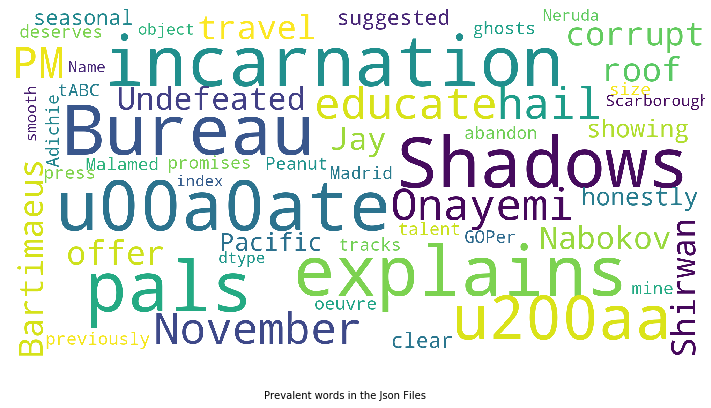

In [ ]:
show_wordcloud(words_dataframe["index"].sample(50), title = 'Prevalent words in the Json Files')

In [ ]:
#Total number of Categories processed (Counting Pickle Files)
import os, os.path

DIR_MAIN = '/content/gdrive/My Drive/Raw_Corpus_Sample/data/'
print ("Total Number of Categories processed : {} ".format(reader.categories()))

categories = [name for name in reader.categories()]

for i in categories:
  DIR = DIR_MAIN + i
  print ('The Category ' + i + ' has processed {:,} pickle files'.format(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])))

Total Number of Categories processed : ['books', 'cinema'] 
The Category books has processed 14 pickle files
The Category cinema has processed 18 pickle files
